In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import string
from string import punctuation
import re
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS

from scipy.stats import shapiro
from scipy.stats import ranksums

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn import svm
from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef

from sklearn.feature_extraction.text import TfidfTransformer
from mlxtend.preprocessing import DenseTransformer


# Data Preparation

In [106]:
#Importing Data
shakira = pd.read_csv('Youtube05-Shakira.csv',encoding='utf-8-sig')
shakira.head()

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS
0,z13lgffb5w3ddx1ul22qy1wxspy5cpkz504,dharma pal,2015-05-29T02:30:18.971000,Nice song﻿,0
1,z123dbgb0mqjfxbtz22ucjc5jvzcv3ykj,Tiza Arellano,2015-05-29T00:14:48.748000,I love song ﻿,0
2,z12quxxp2vutflkxv04cihggzt2azl34pms0k,Prìñçeśś Âliś Łøvê Dømíñø Mâđiś™ ﻿,2015-05-28T21:00:08.607000,I love song ﻿,0
3,z12icv3ysqvlwth2c23eddlykyqut5z1h,Eric Gonzalez,2015-05-28T20:47:12.193000,"860,000,000 lets make it first female to reach...",0
4,z133stly3kete3tly22petvwdpmghrlli,Analena López,2015-05-28T17:08:29.827000,shakira is best for worldcup﻿,0


## Attributes

In [5]:
shakira.shape

(370, 5)

There are 370 observations and 5 attributes

In [6]:
shakira.dtypes

COMMENT_ID    object
AUTHOR        object
DATE          object
CONTENT       object
CLASS          int64
dtype: object

In [3]:
#Changing Datatype of Date Attribute
shakira['DATE']=shakira['DATE'].astype('datetime64[ns]')
shakira.head(3)

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS
0,z13lgffb5w3ddx1ul22qy1wxspy5cpkz504,dharma pal,2015-05-29 02:30:18.971,Nice song﻿,0
1,z123dbgb0mqjfxbtz22ucjc5jvzcv3ykj,Tiza Arellano,2015-05-29 00:14:48.748,I love song ﻿,0
2,z12quxxp2vutflkxv04cihggzt2azl34pms0k,Prìñçeśś Âliś Łøvê Dømíñø Mâđiś™ ﻿,2015-05-28 21:00:08.607,I love song ﻿,0


All the attributes except for Class are measured as an object. Class is a categorical variable because it represents spam vs non-spam, however it doesn't need to be converted from integer to object because the classifers that will be used later on in the project needs the variable to be measured as an integer. Date is also read as an object, however I converted it to datetime to be more accurate.

In [8]:
shakira.describe(include='all')

C:\Users\Vanessa\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS
count,370,370,370,370,370.000000
unique,369,319,369,331,NaN
top,_2viQ_Qnc68fX3dYsfYuM-m4ELMJvxOQBmBOFHqGOk0,5000palo,2013-10-05 00:57:25.078000,Hi. Check out and share our songs.,NaN
freq,2,7,2,4,NaN
first,NaN,NaN,2013-07-12 22:33:27.916000,NaN,NaN
last,NaN,NaN,2015-05-29 02:30:18.971000,NaN,NaN
mean,NaN,NaN,NaN,NaN,0.470270
std,NaN,NaN,NaN,NaN,0.499791
min,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,0.000000


From the summary of all the attributes you can already see in that in Content there are comments that appear multiple times which could be an indicator of spam. There is also at leat 1 Authour that posts multiple comments which is also an indicator of spam. The dataset also has a Comment_ID which appears twice which could be a duplicate.

## Looking for Duplicates

In [4]:
print("Total Number of Comment_IDs:",shakira.AUTHOR.shape[0])
print("Total Number of Unique Comment_IDs:" , shakira['COMMENT_ID'].nunique())

Total Number of Comment_IDs: 370
Total Number of Unique Comment_IDs: 369


In [5]:
#Checking for Duplicates
duplicated_row = shakira[shakira.duplicated()]
print(duplicated_row)
#passes over the first occurance of the duplicate and prints the second occurance

                                      COMMENT_ID          AUTHOR  \
212  _2viQ_Qnc68fX3dYsfYuM-m4ELMJvxOQBmBOFHqGOk0  tyler sleetway   

                       DATE      CONTENT  CLASS  
212 2013-10-05 00:57:25.078  so beutiful      0  


In [6]:
shakira.loc[(shakira['COMMENT_ID']=='_2viQ_Qnc68fX3dYsfYuM-m4ELMJvxOQBmBOFHqGOk0')]

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS
211,_2viQ_Qnc68fX3dYsfYuM-m4ELMJvxOQBmBOFHqGOk0,tyler sleetway,2013-10-05 00:57:25.078,so beutiful,0
212,_2viQ_Qnc68fX3dYsfYuM-m4ELMJvxOQBmBOFHqGOk0,tyler sleetway,2013-10-05 00:57:25.078,so beutiful,0


In [107]:
#Removing the duplicate
shakira = shakira.drop([212])
shakira.shape

(369, 5)

I choose to remove the duplicate because seems to be a dulicate due to error and not an act of spam because the Class is ham, the comment is related to the video, it was posted at the same exact time and the Comment_ID such is suppose to be unique is not.

## Missing Values

In [12]:
shakira.isnull().sum(axis=0)

COMMENT_ID    0
AUTHOR        0
DATE          0
CONTENT       0
CLASS         0
dtype: int64

There are no missing values

## Imbalance in Data

([<matplotlib.axis.XTick at 0x1da25114208>,
 [Text(0, 0, 'Ham'), Text(1, 0, 'Spam')])

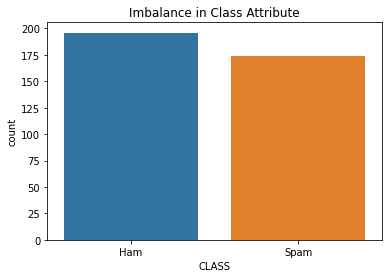

In [13]:
sns.countplot(x='CLASS', data= shakira)
plt.title("Imbalance in Class Attribute")
plt.xticks([0, 1], ['Ham', 'Spam'])

In [14]:
shakira['CLASS'].value_counts()

0    196
1    174
Name: CLASS, dtype: int64

In [15]:
print("Percentage of Ham:",round(((195/shakira.shape[0])*100),2))
print("Percentage of Spam:",round(((174/shakira.shape[0])*100),2))

Percentage of Ham: 52.7
Percentage of Spam: 47.03


The data is balanced

# Exploratory Analysis 

## Univariate Analysis

### Comment Length

In [7]:
shakira['CONTENT_LENGTH'] = shakira.CONTENT.apply(lambda x: x.split())
#Create a new column based on CONTENT and tokenize the text
shakira['CONTENT_LENGTH'] = shakira.CONTENT.apply(lambda x: x.lower())
#convert all the characters to lowercase
shakira['CONTENT_LENGTH'] = shakira.CONTENT.apply(lambda x: ''.join([c for c in x if c not in punctuation]))
#Remove the puncutation
shakira['CONTENT_LENGTH']=shakira.CONTENT.apply(lambda x:len(x))
#Find the length of each comment
shakira.head()

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS,CONTENT_LENGTH
0,z13lgffb5w3ddx1ul22qy1wxspy5cpkz504,dharma pal,2015-05-29 02:30:18.971,Nice song﻿,0,10
1,z123dbgb0mqjfxbtz22ucjc5jvzcv3ykj,Tiza Arellano,2015-05-29 00:14:48.748,I love song ﻿,0,13
2,z12quxxp2vutflkxv04cihggzt2azl34pms0k,Prìñçeśś Âliś Łøvê Dømíñø Mâđiś™ ﻿,2015-05-28 21:00:08.607,I love song ﻿,0,13
3,z12icv3ysqvlwth2c23eddlykyqut5z1h,Eric Gonzalez,2015-05-28 20:47:12.193,"860,000,000 lets make it first female to reach...",0,86
4,z133stly3kete3tly22petvwdpmghrlli,Analena López,2015-05-28 17:08:29.827,shakira is best for worldcup﻿,0,29


In [18]:
print("Average Comment Length:",shakira['CONTENT_LENGTH'].mean())
print("Minimum Comment Length:",shakira['CONTENT_LENGTH'].min())
print("Maximum Comment Length:",shakira['CONTENT_LENGTH'].max())

Average Comment Length: 108.92432432432433
Minimum Comment Length: 2
Maximum Comment Length: 1125


Text(0.5, 1.0, 'Distribution of comment length')

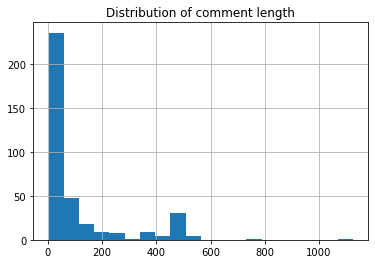

In [19]:
shakira['CONTENT_LENGTH'].hist(bins=20)
plt.title('Distribution of comment length')

Most comments in the dataset are less than 50 words meaning that most users leave shorter comments.

### Dates

In [20]:
#extracting the year and month from the DATE attribute
shakira['YEAR_MONTH'] = shakira['DATE'].dt.strftime('%Y-%m')
shakira.head()

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS,CONTENT_LENGTH,YEAR_MONTH
0,z13lgffb5w3ddx1ul22qy1wxspy5cpkz504,dharma pal,2015-05-29 02:30:18.971,Nice song﻿,0,10,2015-05
1,z123dbgb0mqjfxbtz22ucjc5jvzcv3ykj,Tiza Arellano,2015-05-29 00:14:48.748,I love song ﻿,0,13,2015-05
2,z12quxxp2vutflkxv04cihggzt2azl34pms0k,Prìñçeśś Âliś Łøvê Dømíñø Mâđiś™ ﻿,2015-05-28 21:00:08.607,I love song ﻿,0,13,2015-05
3,z12icv3ysqvlwth2c23eddlykyqut5z1h,Eric Gonzalez,2015-05-28 20:47:12.193,"860,000,000 lets make it first female to reach...",0,86,2015-05
4,z133stly3kete3tly22petvwdpmghrlli,Analena López,2015-05-28 17:08:29.827,shakira is best for worldcup﻿,0,29,2015-05


In [21]:
shakira['YEAR_MONTH'].value_counts()

2015-05    162
2013-10     73
2013-09     43
2013-08     39
2013-07     38
2015-04      8
2013-11      7
Name: YEAR_MONTH, dtype: int64

Text(0.5, 1.0, 'Date of Comments')

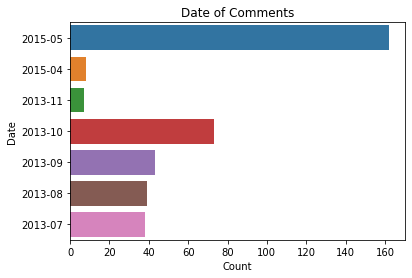

In [22]:
sns.countplot(y='YEAR_MONTH', data= shakira)
plt.xlabel('Count')
plt.ylabel('Date')
plt.title('Date of Comments')

Most of the observations in the dataset are from May of 2015 and the least observations are from November of 2013.

### Frequency of Comments

In [23]:
shakira.AUTHOR.value_counts()

5000palo                            7
Shadrach Grentz                     7
Hidden Love                         5
James Cook                          4
ricky swaggz                        3
                                   ..
Karol Martinez Restrepo Martinez    1
twee gekkos                         1
redouane najja                      1
liliana ciancio                     1
rachel perez                        1
Name: AUTHOR, Length: 319, dtype: int64

<AxesSubplot:xlabel='count', ylabel='AUTHOR'>

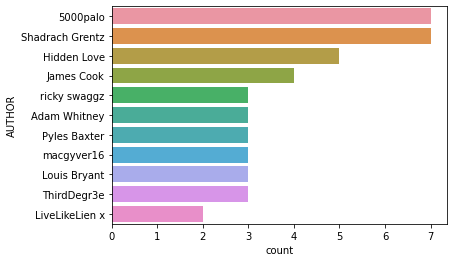

In [25]:
sns.countplot(y='AUTHOR', data=shakira,
              order=shakira.AUTHOR.value_counts().iloc[:11].index)

In [26]:
shakira.loc[(shakira['AUTHOR']=='Shadrach Grentz')]
#Comments from the top commenter

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS,CONTENT_LENGTH,YEAR_MONTH
250,_2viQ_Qnc68dceJbTRNTP2sksMxa_lm35LaCu_jPluY,Shadrach Grentz,2013-09-29 13:59:42.162,Hey Music Fans I really appreciate any of you ...,1,506,2013-09
328,_2viQ_Qnc69zyetF6GsHRzYGyXl4u5kg0Sm-nP-pupI,Shadrach Grentz,2013-08-02 03:15:46.914,Hey Music Fans I really appreciate any of you ...,1,505,2013-08
329,_2viQ_Qnc699u36gNm3NRoq1quIaJWRNrftGEEZM3J4,Shadrach Grentz,2013-08-01 21:43:52.122,Hey Music Fans I really appreciate any of you ...,1,506,2013-08
330,_2viQ_Qnc68LqKGb40V2ImKQYcp1ZqpHrCCMFqMCcA4,Shadrach Grentz,2013-08-01 20:39:15.325,Hey Music Fans I really appreciate any of you ...,1,506,2013-08
334,_2viQ_Qnc69Nq0Ytk1jCpzWPCrpGEk6T7cdVAxfSlAk,Shadrach Grentz,2013-07-29 17:39:24.876,Hey Music Fans I really appreciate any of you ...,1,506,2013-07
341,_2viQ_Qnc6_YN7xFNAg14zX99Y614Salf57yOcrBRSw,Shadrach Grentz,2013-07-21 12:21:37.898,Hey Music Fans I really appreciate all of you ...,1,504,2013-07
358,_2viQ_Qnc6-jk58CPwBnqfbM6oByJH5oPvCtKecLQyo,Shadrach Grentz,2013-07-14 03:11:20.243,Hey Music Fans I really appreciate all of you ...,1,504,2013-07


The user, Shadrach Grentz, left the most comments. All of them are also marked as spam.

In [6]:
shakira['CLEANED_CONTENT'] = shakira['CONTENT'].str.replace(r'(http[s]?\S+)|(\w+\.[A-Za-z]{2,4}\S*)','httpaddr')
shakira.head(3)

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS,CLEANED_CONTENT
0,z13lgffb5w3ddx1ul22qy1wxspy5cpkz504,dharma pal,2015-05-29T02:30:18.971000,Nice song﻿,0,Nice song﻿
1,z123dbgb0mqjfxbtz22ucjc5jvzcv3ykj,Tiza Arellano,2015-05-29T00:14:48.748000,I love song ﻿,0,I love song ﻿
2,z12quxxp2vutflkxv04cihggzt2azl34pms0k,Prìñçeśś Âliś Łøvê Dømíñø Mâđiś™ ﻿,2015-05-28T21:00:08.607000,I love song ﻿,0,I love song ﻿


In [14]:
url = shakira[shakira['CLEANED_CONTENT'].str.contains('httpaddr')]
print(url.shape[0]) #number of comments that contain urls
print(shakira.shape[0]) #total number of comments

40
369


## Bivariate Analysis

Separated spam from non-spam comments in the Class attribute for further analysis

In [9]:
nonspam_comments = shakira.loc[(shakira['CLASS'] == 0)]
nonspam_comments.head(3)

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS,CONTENT_LENGTH
0,z13lgffb5w3ddx1ul22qy1wxspy5cpkz504,dharma pal,2015-05-29 02:30:18.971,Nice song﻿,0,10
1,z123dbgb0mqjfxbtz22ucjc5jvzcv3ykj,Tiza Arellano,2015-05-29 00:14:48.748,I love song ﻿,0,13
2,z12quxxp2vutflkxv04cihggzt2azl34pms0k,Prìñçeśś Âliś Łøvê Dømíñø Mâđiś™ ﻿,2015-05-28 21:00:08.607,I love song ﻿,0,13


In [10]:
spam_comments = shakira.loc[(shakira['CLASS']==1)]
spam_comments.head(3)

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS,CONTENT_LENGTH
7,z12uujnj2sifvzvav04chpypvofvexpoggg,Sudheer Yadav,2015-05-28 10:28:25.133,SEE SOME MORE SONG OPEN GOOGLE AND TYPE Shakir...,1,60
22,z13zjlpo2nbehxwf322gelhzwmqwgn1mt,Raafat saeed,2015-05-27 04:19:29.178,Check out this playlist on YouTube:﻿,1,36
31,z13uhhxp5nvig15yc04citszvtagwtmpqcc,Terry Short,2015-05-26 14:33:52.496,Support the fight for your 4th amendment right...,1,1125


### Content vs Class

#### Spam Comments

In [100]:
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

In [101]:
#text cleaning on spam comments for word cloud
spam_content = spam_comments['CONTENT'] #pulling comments from the dataframe
spam_content = " ".join(comment for comment in spam_content) #convert to a string object
spam_content = spam_content.split() #word tokenization
table = str.maketrans('', '', string.punctuation)
spam_content = [sc.translate(table) for sc in spam_content] #removing punctuation
spam_content = [sc.lower() for sc in spam_content] #converting all text to lowercase
spam_content = ','.join(spam_content) #returns to string object
print(deEmojify(spam_content)) #removing emojis

see,some,more,song,open,google,and,type,shakira,guruofmovie﻿,check,out,this,playlist,on,youtube﻿,support,the,fight,for,your,4th,amendment,right,to,privacy,in,your,home,stop,the,nsa,spying,on,americans,with,the,un,patriot,act,renewal,rand,paul,has,spent,105,hours,on,the,senate,floor,in,a,protest,and,filibuster,fighting,for,our,constitution,that,this,nation,is,founded,on,join,the,fight,at,rand,paul,dot,com,spread,the,word,we,have,someone,that,cares,about,our,nation,email,your,senators,congress,men,and,women,tell,them,to,support,rand,tell,the,news,to,support,rand,too,senator,rand,paul,was,up,until,a,hrefhttpwwwyoutubecomwatchvprpeedmmmq0ampt1m00s100a,am,this,passed,saturday,morning,fighting,for,our,constitution,buy,postponing,the,vote,until,this,week,our,constitution,matters,join,rand,in,the,fight,to,protect,a,hrefhttpithtithta,to,privacy,in,your,home,and,business,senator,rand,paul,was,up,until,a,hrefhttpwwwyoutubecomwatchvprpeedmmmq0ampt1m00s100a,am,this,passed,saturday,morning,fighting,

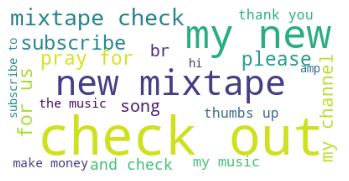

In [102]:
#Building word cloud
stopwords = set(STOPWORDS) #remove stop-words
wordcloud_spam = WordCloud(max_words=20, 
                background_color ='white', 
                stopwords = stopwords).generate(spam_content) 
plt.imshow(wordcloud_spam) 
plt.axis("off")
plt.show()

The top 20 most common words in the spam comments are shown in the word cloud and include: mixtape, check out, subcribe and my music

#### Non-Spam Comments

In [105]:
#text cleaning on non-spam comments for word cloud
nonspam_content = nonspam_comments['CONTENT'] #pulling non-spam comments from dataframe
nonspam_content = " ".join(comment for comment in nonspam_content) #convert to a string object
nonspam_content = nonspam_content.split() #word tokenization
nonspam_content = [nsc.translate(table) for nsc in nonspam_content] #removing punctuation
nonspam_content = [nsc.lower() for nsc in nonspam_content] #converting all text to lowercase
nonspam_content = ','.join(nonspam_content) #returns to string object
print(deEmojify(nonspam_content)) #removing emojis
nonspam_content[:100]

nice,song﻿,i,love,song,﻿,i,love,song,﻿,860000000,lets,make,it,first,female,to,reach,one,billion,share,it,and,replay,it,﻿,shakira,is,best,for,worldcup﻿,the,best,world,cup,song,ever﻿,i,love﻿,awesome,﻿,i,like,shakira﻿,shakira,,waka,waka,br,love,this,song﻿,why,so,many,disliked﻿,i,don39t,think,this,song,will,ever,get,old,﻿,love,song﻿,wery,good﻿,every,time,i,hear,this,song,i,think,about,iniesta39s,goal,against,the,netherlands﻿,whose,watching,this,in,2015,if,so,hi5﻿,i,love,this,song,so,much,lt3br,keep,em39,coming﻿,i,love,this,song,thumsb,up,to,you﻿,waka,best,one﻿,5,years,later,i,still,love,this,song,br,axy665﻿,like﻿,her,voice,sounds,weird,and,plus,she39s,cute,for,a,blonde﻿,why,there,are,so,many,dislikes,this,song,is,so,awesome,it,sounds,like,we,must,stop,be,racists,if,i,could,i,would,like,it,1000000000,times﻿,nice,love,itttttttt,wurkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk﻿,still,watching,in,2015﻿,shakira,is,my,favourite,singer,woooo

'nice,song\ufeff,i,love,song,\ufeff,i,love,song,\ufeff,860000000,lets,make,it,first,female,to,reach,one,billion,shar'

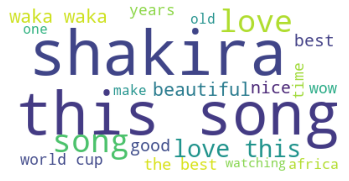

In [106]:
stopwords = set(STOPWORDS)
wordcloud_nonspam = WordCloud(max_words=20, 
                background_color ='white', 
                stopwords = stopwords).generate(nonspam_content) 
plt.imshow(wordcloud_nonspam) 
plt.axis("off")
plt.show()

For non-spam comments, the words/phrases used are related to the video like the name of the artist, the name of the song or the users personal thoughts on the song/video. The most frequently used words include: Shakira, love, song and beautiful.

### Author vs Class

#### Spam Comments

In [29]:
spam_comments['AUTHOR'].value_counts()

Shadrach Grentz     7
Hidden Love         5
James Cook          4
ThirdDegr3e         3
Louis Bryant        3
                   ..
Lisa Matthews       1
gamila Khalil       1
Sudheer Yadav       1
Mazacar Cfc         1
Pauline Martinez    1
Name: AUTHOR, Length: 135, dtype: int64

<AxesSubplot:xlabel='count', ylabel='AUTHOR'>

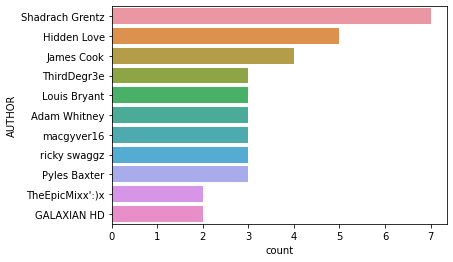

In [30]:
sns.countplot(y='AUTHOR', data=spam_comments,
              order=spam_comments.AUTHOR.value_counts().iloc[:11].index)

In [43]:
spam_comments.loc[(spam_comments['AUTHOR']=='Shadrach Grentz')]

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS,CONTENT_LENGTH,YEAR_MONTH
250,_2viQ_Qnc68dceJbTRNTP2sksMxa_lm35LaCu_jPluY,Shadrach Grentz,2013-09-29 13:59:42.162,Hey Music Fans I really appreciate any of you ...,1,506,2013-09
328,_2viQ_Qnc69zyetF6GsHRzYGyXl4u5kg0Sm-nP-pupI,Shadrach Grentz,2013-08-02 03:15:46.914,Hey Music Fans I really appreciate any of you ...,1,505,2013-08
329,_2viQ_Qnc699u36gNm3NRoq1quIaJWRNrftGEEZM3J4,Shadrach Grentz,2013-08-01 21:43:52.122,Hey Music Fans I really appreciate any of you ...,1,506,2013-08
330,_2viQ_Qnc68LqKGb40V2ImKQYcp1ZqpHrCCMFqMCcA4,Shadrach Grentz,2013-08-01 20:39:15.325,Hey Music Fans I really appreciate any of you ...,1,506,2013-08
334,_2viQ_Qnc69Nq0Ytk1jCpzWPCrpGEk6T7cdVAxfSlAk,Shadrach Grentz,2013-07-29 17:39:24.876,Hey Music Fans I really appreciate any of you ...,1,506,2013-07
341,_2viQ_Qnc6_YN7xFNAg14zX99Y614Salf57yOcrBRSw,Shadrach Grentz,2013-07-21 12:21:37.898,Hey Music Fans I really appreciate all of you ...,1,504,2013-07
358,_2viQ_Qnc6-jk58CPwBnqfbM6oByJH5oPvCtKecLQyo,Shadrach Grentz,2013-07-14 03:11:20.243,Hey Music Fans I really appreciate all of you ...,1,504,2013-07


In [42]:
spam_comments.loc[(spam_comments['AUTHOR']=='Hidden Love')]

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS,CONTENT_LENGTH,YEAR_MONTH
253,_2viQ_Qnc6_onwOgxju-DV6WkqHZEOztCXD04EgEFBU,Hidden Love,2013-09-24 14:29:54.072,Hi. Check out and share our songs.,1,34,2013-09
325,_2viQ_Qnc69r15LuL8TDbisnTJ_hf5RfcyJAyoMC5eo,Hidden Love,2013-08-06 11:40:05.581,Hi. Check out and share our songs.,1,34,2013-08
331,_2viQ_Qnc68Qq98m0mmx4rlprYiD6aYgMb2x3bdupEM,Hidden Love,2013-08-01 09:19:56.654,Hi. Check out and share our songs.,1,34,2013-08
332,_2viQ_Qnc698fLCQzZmRt1CqPhf0L6mchwWG5gsUlzk,Hidden Love,2013-07-31 10:22:02.628,Hi. Check out and share our songs.,1,34,2013-07
333,_2viQ_Qnc68sxLpsBQ1cPk_LLH91SMsRav51KmhIoQw,Hidden Love,2013-07-30 11:22:57.091,Hi.Check out and share our songs.,1,33,2013-07


In [41]:
spam_comments.loc[(spam_comments['AUTHOR']=='James Cook')]

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS,CONTENT_LENGTH,YEAR_MONTH
186,_2viQ_Qnc69ShtSmsaBOGFHrTAVCkLAtpOr40oiL5Yg,James Cook,2013-10-20 13:31:10.083,Stop Wasting Up Your Time and Get Paid To Mes...,1,478,2013-10
192,_2viQ_Qnc68eqIzELH00rh9umGlUKSRuQvWZAXhr_qM,James Cook,2013-10-15 17:00:04.573,Stop Wasting Up Your Time and Get Paid To Mes...,1,478,2013-10
194,_2viQ_Qnc6-grcnVFTtwnhvC9tpgVG33p5a0AZHKlLI,James Cook,2013-10-14 10:35:03.861,Hello Guys...I Found a Way to Make Money Onlin...,1,498,2013-10
200,_2viQ_Qnc69BVRuBYCJ6ik7gdMwTiBRS9DDnTjNs-Gg,James Cook,2013-10-10 18:08:07.815,Hello Guys...I Found a Way to Make Money Onlin...,1,498,2013-10


The top 3 of the spam comment authors post comments directing users to check out their own music or about making money online. They each also post the exact same comment over and over again at different times and on different days.

#### Non-Spam Comments

In [34]:
nonspam_comments['AUTHOR'].value_counts()

5000palo          7
tyler sleetway    2
Alain Bruno       2
Athena Gomez      2
LiveLikeLien x    2
                 ..
Laura Gray        1
hsn moghrbi       1
Aliens Studios    1
Trygve Nilsen     1
marko kacar       1
Name: AUTHOR, Length: 184, dtype: int64

<AxesSubplot:xlabel='count', ylabel='AUTHOR'>

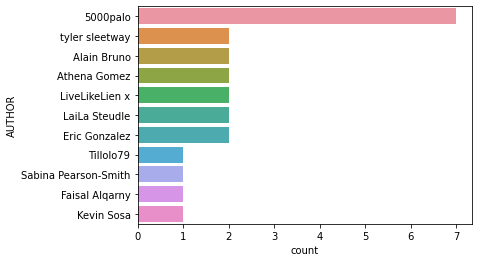

In [35]:
sns.countplot(y='AUTHOR', data=nonspam_comments,
              order=nonspam_comments.AUTHOR.value_counts().iloc[:11].index)

In [36]:
nonspam_comments.loc[(nonspam_comments['AUTHOR']=='5000palo')]['CONTENT'][:50]

215     She is perfect
221    I want new song
223        Shakira :-*
234        Shakira :-*
261     She is perfect
264        Shakira :-*
286        Shakira :-*
Name: CONTENT, dtype: object

In [37]:
nonspam_comments.loc[(nonspam_comments['AUTHOR']=='LaiLa Steudle')]['CONTENT'][:50]

145             I love you Shakiria!!!!!!﻿
146    Me and my aunt love this song!!!!!﻿
Name: CONTENT, dtype: object

One the other hand the non-spam users post comments related to the song or video and about their love for the artist. Also, leaving more than 2 comments is considered an outlier.

### Comment Length vs Class 

#### Spam Comments

Text(0.5, 1.0, 'Distribution of Spam Comment Length')

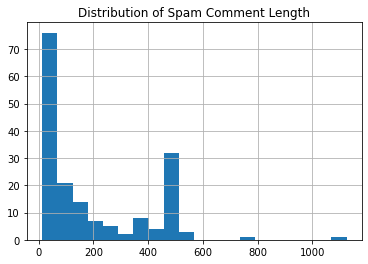

In [44]:
spam_comments['CONTENT_LENGTH'].hist(bins=20)
plt.title('Distribution of Spam Comment Length')

In [45]:
print("Average Comment Length:",spam_comments['CONTENT_LENGTH'].mean())
print("Minimum Comment Length:",spam_comments['CONTENT_LENGTH'].min())
print("Maximum Comment Length:",spam_comments['CONTENT_LENGTH'].max())

Average Comment Length: 196.33908045977012
Minimum Comment Length: 13
Maximum Comment Length: 1125


#### Non-Spam Comments

Text(0.5, 1.0, 'Distribution of Non-Spam Comment Length')

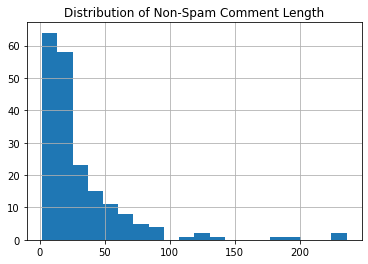

In [46]:
nonspam_comments['CONTENT_LENGTH'].hist(bins=20)
plt.title('Distribution of Non-Spam Comment Length')

In [47]:
print("Average Comment Length:",nonspam_comments['CONTENT_LENGTH'].mean())
print("Minimum Comment Length:",nonspam_comments['CONTENT_LENGTH'].min())
print("Maximum Comment Length:",nonspam_comments['CONTENT_LENGTH'].max())

Average Comment Length: 31.321428571428573
Minimum Comment Length: 2
Maximum Comment Length: 236


Most users leave short comments, however based on the average, minimum and maximum comment length along with the second peak that appears around 450-500 words, spam comments do seem to be longer than non-spam.

To determine if the difference between spam and non-spam comment length is significant. I performed a hypothesis test using Wilcoxon rank sum because the distribution of comment length is not normal (based on the plot in univariate analysis and the Shapiro-Wilk test for normality below) and and the data is not paired. 

In [14]:
#Shapiro-Wilk test for normality
from scipy.stats import shapiro
Stat, p = shapiro(shakira['CONTENT_LENGTH'])
alpha = 0.05
if p > alpha:
    print('sample looks gaussian (fail to reject H0)')
else:
    print('sample does not look gaussian (fail to reject H0)')

sample does not look gaussian (fail to reject H0)


In [11]:
# Wilcoxon rank sum test
from scipy.stats import ranksums
ranksums(spam_comments['CONTENT_LENGTH'], nonspam_comments['CONTENT_LENGTH'])

RanksumsResult(statistic=12.308044696487045, pvalue=8.198539697859426e-35)

The results of the rank sum test show a p-value less than 0.05. Therefore the null hypothesis (the two populations are the same) is rejected at the 5% significance level. There is a difference between the comment length of spam and non-spam comments.

### Uppercase vs Class

In [49]:
shakira['UPPERCASE'] = shakira['CONTENT'].str.findall(r'[A-Z]').str.len()
shakira.head(3)

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS,CLEANED_CONTENT,URLs,UPPERCASE
0,z13lgffb5w3ddx1ul22qy1wxspy5cpkz504,dharma pal,2015-05-29T02:30:18.971000,Nice song﻿,0,nice song,Nice song﻿,1
1,z123dbgb0mqjfxbtz22ucjc5jvzcv3ykj,Tiza Arellano,2015-05-29T00:14:48.748000,I love song ﻿,0,i love song,I love song ﻿,1
2,z12quxxp2vutflkxv04cihggzt2azl34pms0k,Prìñçeśś Âliś Łøvê Dømíñø Mâđiś™ ﻿,2015-05-28T21:00:08.607000,I love song ﻿,0,i love song,I love song ﻿,1


In [50]:
nonspam_comments = shakira.loc[(shakira['CLASS'] == 0)]
spam_comments = shakira.loc[(shakira['CLASS']==1)]

#### Spam Uppercase Characters

Text(0.5, 1.0, 'Number of Uppercase Letters in Spam Comments')

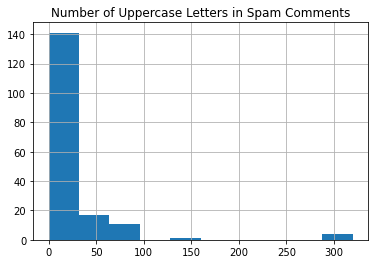

In [54]:
spam_comments['UPPERCASE'].hist()
plt.title('Number of Uppercase Letters in Spam Comments')

In [56]:
print("Average Uppercase Characters Used:",spam_comments['UPPERCASE'].mean())
print("Minimum Uppercase Characters Used:",spam_comments['UPPERCASE'].min())
print("Maximum Uppercase Characters Used:",spam_comments['UPPERCASE'].max())

Average Uppercase Characters Used: 22.85632183908046
Minimum Uppercase Characters Used: 0
Maximum Uppercase Characters Used: 320


#### Non-Spam Uppercase Characters

Text(0.5, 1.0, 'Number of Uppercase Letters in Non-Spam Comments')

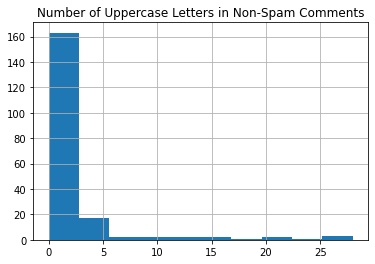

In [52]:
nonspam_comments['UPPERCASE'].hist()
plt.title('Number of Uppercase Letters in Non-Spam Comments')

In [57]:
print("Average Uppercase Characters Used:",nonspam_comments['UPPERCASE'].mean())
print("Minimum Uppercase Characters Used:",nonspam_comments['UPPERCASE'].min())
print("Maximum Uppercase Characters Used:",nonspam_comments['UPPERCASE'].max())

Average Uppercase Characters Used: 2.353846153846154
Minimum Uppercase Characters Used: 0
Maximum Uppercase Characters Used: 28


Spam comments tend to use more uppercase characters perhaps as a way to capture attention. The average number of uppercase letters used in spam is 22 compared to non-spam which averages at 2 uppercase letters. Although both distributions are similar, spam comments have a larger range. The maximum number of uppercase letters used in spam is 320 compared to 28 with non-spam.

### Presence of URLs vs Class

In [10]:
shakira['URLs'] = shakira['CONTENT'].str.replace(r'(http[s]?\S+)|(\w+\.[A-Za-z]{2,4}\S*)','httpaddr')
shakira.head(3)

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS,CLEANED_CONTENT,URLs
0,z13lgffb5w3ddx1ul22qy1wxspy5cpkz504,dharma pal,2015-05-29T02:30:18.971000,Nice song﻿,0,Nice song,Nice song﻿
1,z123dbgb0mqjfxbtz22ucjc5jvzcv3ykj,Tiza Arellano,2015-05-29T00:14:48.748000,I love song ﻿,0,I love song,I love song ﻿
2,z12quxxp2vutflkxv04cihggzt2azl34pms0k,Prìñçeśś Âliś Łøvê Dømíñø Mâđiś™ ﻿,2015-05-28T21:00:08.607000,I love song ﻿,0,I love song,I love song ﻿


In [11]:
url = shakira[shakira['URLs'].str.contains('httpaddr')]
print('Number of comments that contain URLs:', url.shape[0]) #number of comments that contain urls
print('Total number of comments:', shakira.shape[0]) #total number of comments

Number of comments that contain URLs: 40
Total number of comments: 369


In [12]:
nonspam_comments = shakira.loc[(shakira['CLASS'] == 0)]
spam_comments = shakira.loc[(shakira['CLASS']==1)]

In [13]:
spam_url = spam_comments[spam_comments['URLs'].str.contains('httpaddr')]
print('Number of spam comments that contain urls:',spam_url.shape[0]) #number of spam comments that contain urls

nonspam_url = nonspam_comments[nonspam_comments['URLs'].str.contains('httpaddr')]
print('Number of non-spam comments that contain urls:', nonspam_url.shape[0]) # number of non-spam comments that contain urls

Number of spam comments that contain urls: 38
Number of non-spam comments that contain urls: 2


There is a total of 40 comments that contain URLs, 38 of them are identified as spam comments were as only 2 are part of the non-spam class.

# Text Preprocessing

In [90]:
#Convert into lowercase
shakira.loc[:,"CLEANED_CONTENT"] = shakira.CONTENT.apply(lambda x : str.lower(x))
shakira.head(3)

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS,CLEANED_CONTENT
0,z13lgffb5w3ddx1ul22qy1wxspy5cpkz504,dharma pal,2015-05-29T02:30:18.971000,Nice song﻿,0,nice song﻿
1,z123dbgb0mqjfxbtz22ucjc5jvzcv3ykj,Tiza Arellano,2015-05-29T00:14:48.748000,I love song ﻿,0,i love song ﻿
2,z12quxxp2vutflkxv04cihggzt2azl34pms0k,Prìñçeśś Âliś Łøvê Dømíñø Mâđiś™ ﻿,2015-05-28T21:00:08.607000,I love song ﻿,0,i love song ﻿


In [91]:
#Remove punctuation and emojis
shakira.loc[:,"CLEANED_CONTENT"] = shakira.CLEANED_CONTENT.apply(lambda x : " ".join(re.findall('[\w]+',x)))
shakira.head(6)[['CONTENT' ,'CLEANED_CONTENT']]

,CONTENT,CLEANED_CONTENT
0,Nice song﻿,nice song
1,I love song ﻿,i love song
2,I love song ﻿,i love song
3,"860,000,000 lets make it first female to reach...",860 000 000 lets make it first female to reach...
4,shakira is best for worldcup﻿,shakira is best for worldcup
5,The best world cup song ever!!!!﻿,the best world cup song ever


In [71]:
#remove stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
print('List of Stop Words:', stop_words)

shakira['CLEANED_CONTENT'] = shakira.CLEANED_CONTENT.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
shakira.head(5)

List of Stop Words: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'sa

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS,CLEANED_CONTENT
0,z13lgffb5w3ddx1ul22qy1wxspy5cpkz504,dharma pal,2015-05-29T02:30:18.971000,Nice song﻿,0,nice song
1,z123dbgb0mqjfxbtz22ucjc5jvzcv3ykj,Tiza Arellano,2015-05-29T00:14:48.748000,I love song ﻿,0,love song
2,z12quxxp2vutflkxv04cihggzt2azl34pms0k,Prìñçeśś Âliś Łøvê Dømíñø Mâđiś™ ﻿,2015-05-28T21:00:08.607000,I love song ﻿,0,love song
3,z12icv3ysqvlwth2c23eddlykyqut5z1h,Eric Gonzalez,2015-05-28T20:47:12.193000,"860,000,000 lets make it first female to reach...",0,numbr numbr numbr lets make first female reach...
4,z133stly3kete3tly22petvwdpmghrlli,Analena López,2015-05-28T17:08:29.827000,shakira is best for worldcup﻿,0,shakira best worldcup


In [16]:
#Stemming
import nltk
porter = nltk.PorterStemmer()
shakira['CLEANED_CONTENT'] = shakira.CLEANED_CONTENT.apply(lambda x: ' '.join(porter.stem(word) for word in x.split()))
shakira.head(3)
#converts youtube to youtub

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS,CLEANED_CONTENT
0,z13lgffb5w3ddx1ul22qy1wxspy5cpkz504,dharma pal,2015-05-29T02:30:18.971000,Nice song﻿,0,nice song
1,z123dbgb0mqjfxbtz22ucjc5jvzcv3ykj,Tiza Arellano,2015-05-29T00:14:48.748000,I love song ﻿,0,love song
2,z12quxxp2vutflkxv04cihggzt2azl34pms0k,Prìñçeśś Âliś Łøvê Dømíñø Mâđiś™ ﻿,2015-05-28T21:00:08.607000,I love song ﻿,0,love song


In [92]:
# normalization simplify websites
shakira['CLEANED_CONTENT'] = shakira['CLEANED_CONTENT'].str.replace(r'(http[s]?\S+)|(\w+\.[A-Za-z]{2,4}\S*)','httpaddr')
shakira.head(3)

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS,CLEANED_CONTENT
0,z13lgffb5w3ddx1ul22qy1wxspy5cpkz504,dharma pal,2015-05-29T02:30:18.971000,Nice song﻿,0,nice song
1,z123dbgb0mqjfxbtz22ucjc5jvzcv3ykj,Tiza Arellano,2015-05-29T00:14:48.748000,I love song ﻿,0,i love song
2,z12quxxp2vutflkxv04cihggzt2azl34pms0k,Prìñçeśś Âliś Łøvê Dømíñø Mâđiś™ ﻿,2015-05-28T21:00:08.607000,I love song ﻿,0,i love song


In [93]:
# normalization simplify numbers
shakira['CLEANED_CONTENT'] = shakira['CLEANED_CONTENT'].str.replace(r'\d+(\.\d+)?', 'numbr')
shakira.head(3)

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS,CLEANED_CONTENT
0,z13lgffb5w3ddx1ul22qy1wxspy5cpkz504,dharma pal,2015-05-29T02:30:18.971000,Nice song﻿,0,nice song
1,z123dbgb0mqjfxbtz22ucjc5jvzcv3ykj,Tiza Arellano,2015-05-29T00:14:48.748000,I love song ﻿,0,i love song
2,z12quxxp2vutflkxv04cihggzt2azl34pms0k,Prìñçeśś Âliś Łøvê Dømíñø Mâđiś™ ﻿,2015-05-28T21:00:08.607000,I love song ﻿,0,i love song


In [94]:
#Fix spelling/slang for some words
shakira['CLEANED_CONTENT'] = shakira['CLEANED_CONTENT'].str.replace(r'gooo+', 'goo')
#shakira['CLEANED_CONTENT'] = shakira['CLEANED_CONTENT'].str.replace(r'luv', 'love') no luv in text
#can fix itttttttt 
shakira.head(3)

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS,CLEANED_CONTENT
0,z13lgffb5w3ddx1ul22qy1wxspy5cpkz504,dharma pal,2015-05-29T02:30:18.971000,Nice song﻿,0,nice song
1,z123dbgb0mqjfxbtz22ucjc5jvzcv3ykj,Tiza Arellano,2015-05-29T00:14:48.748000,I love song ﻿,0,i love song
2,z12quxxp2vutflkxv04cihggzt2azl34pms0k,Prìñçeśś Âliś Łøvê Dømíñø Mâđiś™ ﻿,2015-05-28T21:00:08.607000,I love song ﻿,0,i love song


In [95]:
#Remove whitespace at the beginning or end of a line
shakira['CLEANED_CONTENT'] = shakira.CLEANED_CONTENT.str.replace(r'\s+', ' ')
processed = shakira.CLEANED_CONTENT.str.replace(r'^\s+|\s+?$', '')
shakira.head(3)

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS,CLEANED_CONTENT
0,z13lgffb5w3ddx1ul22qy1wxspy5cpkz504,dharma pal,2015-05-29T02:30:18.971000,Nice song﻿,0,nice song
1,z123dbgb0mqjfxbtz22ucjc5jvzcv3ykj,Tiza Arellano,2015-05-29T00:14:48.748000,I love song ﻿,0,i love song
2,z12quxxp2vutflkxv04cihggzt2azl34pms0k,Prìñçeśś Âliś Łøvê Dømíñø Mâđiś™ ﻿,2015-05-28T21:00:08.607000,I love song ﻿,0,i love song


In [73]:
shakira.head(15)[['CONTENT','CLEANED_CONTENT']]

,CONTENT,CLEANED_CONTENT
0,Nice song﻿,nice song
1,I love song ﻿,love song
2,I love song ﻿,love song
3,"860,000,000 lets make it first female to reach...",numbr numbr numbr let make first femal reach o...
4,shakira is best for worldcup﻿,shakira best worldcup
5,The best world cup song ever!!!!﻿,best world cup song ever
6,I love﻿,love
7,SEE SOME MORE SONG OPEN GOOGLE AND TYPE Shakir...,see song open googl type shakira guruofmovi
8,Awesome ﻿,awesom
9,I like shakira..﻿,like shakira


# Model - Prediction Results

## Splitting Data

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(shakira.CONTENT,shakira.CLASS, test_size=0.30, random_state =100)

In [77]:
Xc_train, Xc_test, yc_train, yc_test = train_test_split(shakira.CLEANED_CONTENT,shakira.CLASS, test_size=0.30, random_state = 101)

In [126]:
#no stemming or stop-word removal
Xs_train, Xs_test, ys_train, ys_test = train_test_split(shakira.CLEANED_CONTENT,shakira.CLASS, test_size=0.30, random_state = 12)

## TF-IDF vs Bag-of-Words

Before beginning the models, I wanted to test whether TF-IDF or Bag-of-Words (BoW) would be more appropriate for representing the text data. BoW focused solely on term frequency while TF-IDF puts more weight on words that occur infrequently.

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
v = CountVectorizer()
X_train_count = v.fit_transform(Xc_train.values)

In [22]:
from sklearn.feature_extraction.text import TfidfTransformer 
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf_transformer.fit(X_train_count)

TfidfTransformer()

In [23]:
# print idf values 
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=v.get_feature_names(),columns=["idf_weights"]) 
 
# sort ascending 
df_idf.sort_values(by=['idf_weights'], ascending = True).head(10)

,idf_weights
numbr,2.266369
song,2.531476
check,2.605584
love,2.893266
shakira,3.001480
subscrib,3.091092
money,3.155631
make,3.260991
pleas,3.298732
like,3.298732


Based on testing with TF-IDF and exploratory analysis results from the word clouds, the words that were given lower IDF scores were words that occurred frequently in either the spam or ham class and although IDF did not see it as important, it was important to distinguishing between classes. For instance, the words “song”, “love” and “Shakira” were among the 10 most frequent words used in the Ham class, however they were also the top 10 lowest IDF scores. On the other hand, the words “check”, “subscribe”, “money” and “please” were among the 10 most frequent words used in the Spam comment but also received the top 10 lowest IDF scores. Therefore, these words are valuable to distinguish the classes but are suppressed by IDF, therefore I chose to use BoW for modelling. 

## Modelling - Uncleaned Data

### Multinominal Naïve Bayes

In [7]:
clf_umn = Pipeline([
    ('vectorizer', CountVectorizer()), #convert text to countvectorizer
    ('nb', MultinomialNB()) #then apply multinomal naive bayes
])

In [8]:
scoring = {'accuracy': 'accuracy',
           'recall': 'recall',
           'precision': 'precision',
           'f1': 'f1'}
cross_val_scores_umn = cross_validate(clf_umn, X_train, y_train, cv=3, scoring=scoring)
cross_val_scores_umn

{'fit_time': array([0.26566315, 0.0059855 , 0.00695634]),
 'score_time': array([0.03974986, 0.00498629, 0.00503802]),
 'test_accuracy': array([0.94186047, 0.88372093, 0.96511628]),
 'test_recall': array([0.9       , 0.85      , 0.92682927]),
 'test_precision': array([0.97297297, 0.89473684, 1.        ]),
 'test_f1': array([0.93506494, 0.87179487, 0.96202532])}

### Gaussian Naïve Bayes

In [9]:
clf_ug = Pipeline([
    ('vect', CountVectorizer()),
    ('to_dense', DenseTransformer()),
    ('clf', GaussianNB())   
])

In [10]:
cross_val_scores_ug = cross_validate(clf_ug, X_train, y_train, cv=3, scoring=scoring)
cross_val_scores_ug

{'fit_time': array([0.0176363 , 0.01396465, 0.01296782]),
 'score_time': array([0.01024985, 0.00798035, 0.01218009]),
 'test_accuracy': array([0.95348837, 0.89534884, 0.89534884]),
 'test_recall': array([0.975     , 0.975     , 0.92682927]),
 'test_precision': array([0.92857143, 0.82978723, 0.86363636]),
 'test_f1': array([0.95121951, 0.89655172, 0.89411765])}

##  Modelling - Cleaned Data

### Multinominal Naïve Bayes

In [22]:
clf_cmn = Pipeline([
    ('vectorizer', CountVectorizer()), #convert text to countvectorizer
    ('nb', MultinomialNB()) #then apply multinomal naive bayes
])

In [23]:
cross_val_scores_cmn = cross_validate(clf_cmn, Xc_train, yc_train, cv=3, scoring=scoring)
cross_val_scores_cmn

{'fit_time': array([0.00900817, 0.0059824 , 0.00498414]),
 'score_time': array([0.00598478, 0.00499105, 0.00498676]),
 'test_accuracy': array([0.95348837, 0.94186047, 0.94186047]),
 'test_recall': array([0.97435897, 0.875     , 0.925     ]),
 'test_precision': array([0.92682927, 1.        , 0.94871795]),
 'test_f1': array([0.95      , 0.93333333, 0.93670886])}

### Gaussian Naïve Bayes

In [25]:
clf_cg = Pipeline([
    ('vect', CountVectorizer()),
    ('to_dense', DenseTransformer()),
    ('clf', GaussianNB())   
])

In [26]:
cross_val_scores_cg = cross_validate(clf_cg, Xc_train, yc_train, cv=3, scoring=scoring)
cross_val_scores_cg

{'fit_time': array([0.01354432, 0.01097727, 0.00698757]),
 'score_time': array([0.00852513, 0.00797462, 0.00797105]),
 'test_accuracy': array([0.89534884, 0.91860465, 0.94186047]),
 'test_recall': array([1.   , 0.925, 0.975]),
 'test_precision': array([0.8125    , 0.90243902, 0.90697674]),
 'test_f1': array([0.89655172, 0.91358025, 0.93975904])}

## Improving the Model

The main objective of cleaning the text data is to remove data which is redundant and which does not provide useful information regarding correctly classifying the comments. However when comparing the results with the clean and uncleaned text data above, the uncleaned text data tended to perform better. It can be said that completely cleaning the text data results in a loss in important information for classifying the comments. After not cleaning the data results in many features and the classifier could take too long to train especially if applied to filtering thousands of comments.

As a way to improve the results with cleaned text data. I only applied punctuation/emoji removal, removed whitespaces, converted to lowercase and simplified websites and numbers. No stemming and stop-word removal were performed. The results are shown below.

In [35]:
clf_nb = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [36]:
cross_val_scores_nb = cross_validate(clf_nb, Xs_train, ys_train, cv=3, scoring=scoring)
cross_val_scores_nb

{'fit_time': array([0.01209116, 0.00697994, 0.00797391]),
 'score_time': array([0.00586104, 0.00598454, 0.00598621]),
 'test_accuracy': array([0.94186047, 0.93023256, 0.94186047]),
 'test_recall': array([0.95238095, 0.92857143, 0.97619048]),
 'test_precision': array([0.93023256, 0.92857143, 0.91111111]),
 'test_f1': array([0.94117647, 0.92857143, 0.94252874])}

### Gaussian Naive Bayes

In [127]:
clf_ng = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('to_dense', DenseTransformer()),
    ('nb', GaussianNB())
])

In [38]:
cross_val_scores_ng = cross_validate(clf_ng, Xs_train, ys_train, cv=3, scoring=scoring)
cross_val_scores_ng

{'fit_time': array([0.01495981, 0.00997305, 0.00997305]),
 'score_time': array([0.00897622, 0.00700998, 0.00891924]),
 'test_accuracy': array([0.88372093, 0.86046512, 0.86046512]),
 'test_recall': array([1.        , 0.92857143, 1.        ]),
 'test_precision': array([0.80769231, 0.8125    , 0.77777778]),
 'test_f1': array([0.89361702, 0.86666667, 0.875     ])}

## Final Model Test Set

### Multinomial Fully Cleaned Model

In [77]:
clf_cmn.fit(Xc_train, yc_train)

Pipeline(steps=[('vectorizer', CountVectorizer()), ('nb', MultinomialNB())])

In [78]:
y_pred_cmn=clf_cmn.predict(Xc_test)
confusion_matrix(yc_test, y_pred_cmn)

array([[53,  5],
       [ 2, 51]], dtype=int64)

In [79]:
print("Accuracy:", clf_cmn.score(Xc_test, yc_test))
print("F1-Score:", f1_score(yc_test, y_pred_cmn, average='weighted'))

Accuracy: 0.9369369369369369
F1-Score: 0.9369676569481716
